# Quora

In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AdamWeightDecay,
)
from datasets import load_dataset, load_metric, ClassLabel
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def remove_semantic_duplicates(questions, vectorizer, jaccard_threshold=0.9):
    # Transform the text data into TF-IDF vectors
    questions_df = questions.to_pandas()
    ids = []
    texts = []

    # Iterate through each row in the DataFrame
    for index, row in questions_df.iterrows():
        # Extract 'id' and 'text' values from the 'questions' column
        id_list = row['questions']['id']
        text_list = row['questions']['text']

        # Extend the lists with values from this row
        ids.extend(id_list)
        texts.extend(text_list)

    # Create a new DataFrame with 'id' and 'text' columns
    new_df = pd.DataFrame({'id': ids, 'text': texts}).set_index('id')
    #texts = questions['text'][0]+questions['text'][1]
    tfidf_matrix = vectorizer.fit_transform(new_df)
    
    # Calculate the Jaccard similarity matrix based on TF-IDF vectors
    jaccard_sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)
    print(jaccard_sim_matrix)
    # Create a list to keep track of the indices to drop
    indices_to_drop = []
    
    # Iterate through the Jaccard similarity matrix to identify duplicates
    for i in range(len(new_df)):
        if i not in indices_to_drop:
            for j in range(i + 1, len(new_df)):
                if jaccard_sim_matrix[i, j] > jaccard_threshold:
                    indices_to_drop.append(j)
    
    
    return indices_to_drop

def val_shuffle_train_test_split(labels, train_size):
    train_indices, test_indices = train_test_split(
        range(len(labels)),
        train_size=train_size,  # You can adjust the test size as needed
        stratify=labels,  # Perform stratified sampling based on labels
        random_state=42  # Set a random state for reproducibility
    )
    return train_indices, test_indices

def plot_text_length(total_questions):
    text_lengths = [len(questions['text'][0].split())+len(questions['text'][1].split()) for questions in total_questions]

    # Create a histogram to visualize the distribution of text lengths
    plt.hist(text_lengths, bins=50, edgecolor='k')
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    return

def tokenize_function(example, tokenizer):
    questions = example["questions"]
    t1 = [t["text"][0] for t in questions]
    t2 = [t["text"][1] for t in questions]
    return tokenizer(t1, t2, padding="max_length", max_length=50, truncation=True)

def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels)["precision"]
    recall = metric2.compute(predictions=predictions, references=labels)["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels)["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    
def log_fn(metrics):
    print(metrics)
    


In [6]:
def main():
    
    # Model setup
    mname='distilbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(mname)
    config = AutoConfig.from_pretrained(mname)
    config.num_attention_heads = 8
    config.hidden_size = 512  # Desired hidden size. Baseline is 768 (64x12)
    #The following below are recommended by ChatGPT. Tey are added for the purpose of notes
    config.num_hidden_layers = 6 # This is baseline
    # Modify the dropout rate (e.g., set it to 0.2 for 20% dropout)
    config.attention_probs_dropout_prob = 0.2 #Baseline is 0.1
    config.hidden_dropout_prob = 0.2 #Baseline is 0.1

    # Create the modified DistilBERT model for sequence classification with the new configuration
    model = AutoModelForSequenceClassification.from_config(config).to(device)
    #model = AutoModelForSequenceClassification.from_pretrained(mname, num_labels=2).to(device)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    # Load and preprocess dataset
    dataset = load_dataset("quora", "en")
    print(f"The dataset features are: {dataset['train'].features}")
    # Compute the lengths of each text sample
    dataset_questions = dataset["train"]
    #duplicate_indices = remove_semantic_duplicates(dataset_questions, tfidf_vectorizer, jaccard_threshold=0.9)
    plot_text_length(dataset_questions["questions"])
    
    labels = dataset['train']['is_duplicate']
    # Use stratified sampling to select 5,000 samples while maintaining label ratios
    sample_indices,_ = val_shuffle_train_test_split(labels, train_size=50000)
    
    # Select the samples based on the indices
    sampled_dataset = dataset['train'].select(sample_indices)
    print(f"The sampled dataset is: {sampled_dataset}")
    # Perform stratified split
    train_indices, test_indices = val_shuffle_train_test_split(sampled_dataset['is_duplicate'], train_size=0.7)

    # Split the dataset using the obtained indices
    train_dataset = sampled_dataset.select(train_indices)
    test_dataset = sampled_dataset.select(test_indices)
    
    # Further split the training dataset into training and validation
    train_indices, val_indices = val_shuffle_train_test_split(train_dataset['is_duplicate'], train_size=6/7)
    
    # Split the training dataset using the obtained indices
    val_dataset = train_dataset.select(val_indices)
    train_dataset = train_dataset.select(train_indices)
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    
    train_dataset = train_dataset.map(lambda example: tokenize_function(example, tokenizer), batched=True)
    test_dataset = test_dataset.map(lambda example: tokenize_function(example, tokenizer), batched=True)

    input_id_lengths = [len(questions) for questions in train_dataset["input_ids"]]
    
    train_dataset = train_dataset.cast_column(
        "is_duplicate", ClassLabel(num_classes=2, names=["not_duplicate", "duplicate"])
    ).remove_columns("questions").rename_column("is_duplicate", "labels")
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset = test_dataset.cast_column(
        "is_duplicate", ClassLabel(num_classes=2, names=["not_duplicate", "duplicate"])
    ).remove_columns("questions").rename_column("is_duplicate", "labels")
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    

    # Define training arguments and trainer
    training_args = TrainingArguments(
        output_dir="./quora_qpair_similarity",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_first_step=True,
        logging_steps=10,  # Print logs at every 100 logging steps
        per_device_train_batch_size=16,
        #weight_decay = 0.01,
        learning_rate = 1e-5,
        num_train_epochs=10,
        logging_dir="./logs",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        #optimizers=AdamWeightDecay()
    )

    # Train the model
    trainer.train()
    trainer.save_model("./saved_model")
    return trainer


The dataset features are: {'questions': Sequence(feature={'id': Value(dtype='int32', id=None), 'text': Value(dtype='string', id=None)}, length=-1, id=None), 'is_duplicate': Value(dtype='bool', id=None)}


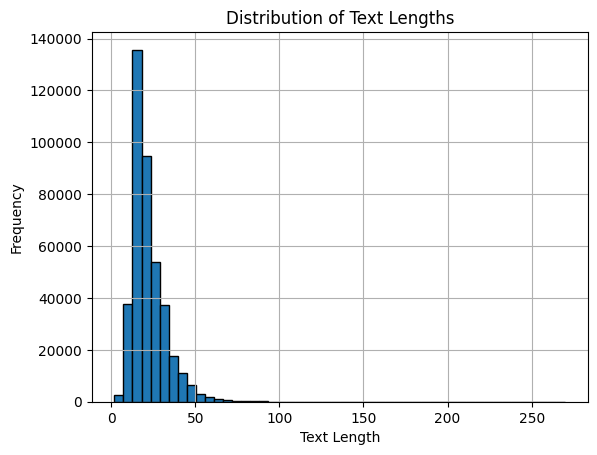

The sampled dataset is: Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 50000
})
Training dataset size: 30000
Validation dataset size: 5000
Testing dataset size: 15000


D:\projects\venv310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.511100,0.562316,0.712400,0.670759,0.434092,0.527077
2,0.574300,0.551959,0.726333,0.676174,0.496569,0.572618
3,0.467500,0.553702,0.733933,0.668776,0.553449,0.605671
4,0.524200,0.579883,0.704133,0.582041,0.704586,0.637478
5,0.466700,0.572607,0.729200,0.651416,0.573312,0.609873
6,0.417700,0.584408,0.733267,0.663545,0.563019,0.609163
7,0.374400,0.604698,0.731667,0.656399,0.573312,0.612048
8,0.494700,0.629326,0.722733,0.623191,0.629830,0.626493
9,0.394100,0.629230,0.727200,0.633149,0.620802,0.626915
10,0.345300,0.644091,0.729467,0.641060,0.607259,0.623702


In [7]:
trainer=main()

In [8]:
trainer.evaluate()

{'eval_loss': 0.6440908908843994,
 'eval_accuracy': 0.7294666666666667,
 'eval_precision': 0.6410598551277163,
 'eval_recall': 0.6072589382448538,
 'eval_f1': 0.6237017804154302,
 'eval_runtime': 24.0641,
 'eval_samples_per_second': 623.336,
 'eval_steps_per_second': 77.917,
 'epoch': 10.0}